In [1]:
import numpy as np
import tensorflow as tf
from keras import layers
from PIL import Image
from IPython.display import display
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.models import Model
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt


2023-05-17 10:06:31.603377: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 10:06:31.903487: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-17 10:06:31.903531: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-17 10:06:33.460167: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
target_image_size = (75, 75)
model_name = ''
num_classes = 17


In [ ]:
# # 讀取資料集
# x_train = np.load('train_image.npy')
# y_train = np.load('train_label.npy')
# x_test = np.load('test_image.npy')
# y_test = np.load('test_label.npy')

In [3]:

train_datagen = ImageDataGenerator(
    rescale=1./255,  # 对图像进行缩放，将像素值归一化到[0,1]之间
    rotation_range=30,  # 随机旋转角度范围
    width_shift_range=0.2,  # 随机水平平移的范围
    height_shift_range=0.2,  # 随机竖直平移的范围
    shear_range=0.1,  # 剪切强度
    zoom_range=0.2,  # 随机缩放范围
    horizontal_flip=False,  # 随机水平翻转
    fill_mode='nearest'  # 填充方式
)

train_dir = 'Dataset/train/'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_image_size,
    batch_size=32,
    class_mode='categorical'
)

# 创建验证集的 ImageDataGenerator 对象
validation_datagen =  ImageDataGenerator(rescale=1./255)

val_dir = 'Dataset/val/'

# 加载验证集
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=target_image_size,
    batch_size=32,
    class_mode='categorical'
)

Found 1485 images belonging to 17 classes.
Found 476 images belonging to 17 classes.


In [ ]:
# x_train = x_train.reshape(len(x_train), 128, 128, 3).astype("float32")
# x_train = x_train / 255

# x_test = x_test.reshape(len(x_test), 128, 128, 3).astype("float32")
# x_test = x_test / 255

In [ ]:
# label_map = {
#              "1-1": 0, "1-2": 1, "2-1": 2, "2-2": 3, "3-1": 4,
#              "3-2": 5, "4-1": 6, "4-2": 7, "5-1": 8, "5-2": 9,
#              "6-1": 10, "6-2": 11, "6-3": 12, "7-1": 13, "8-1": 14,
#              "8-2": 15,"8-3": 16
#             }
# label_indices = [label_map[label] for label in y_train]
# y_train_one_hot = tf.one_hot(label_indices, depth=len(label_map))
# print(y_train_one_hot)
# label_indices = [label_map[label] for label in y_test]
# y_test_one_hot = tf.one_hot(label_indices, depth=len(label_map))
# print(y_test_one_hot)

In [ ]:
# # 創建模型
# model = tf.keras.Sequential([
#     layers.Conv2D(64, (5, 5), activation='relu', input_shape=(128, 128, 3)),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.3),
#     layers.Conv2D(128, (5, 5), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.3),
#     layers.Conv2D(256, (5, 5), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.3),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.5),
#     layers.Dense(17, activation='softmax')
# ])


# checkpoint = ModelCheckpoint(filepath='model.h5', monitor='val_accuracy', save_best_only=True)

# # 編譯模型
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

In [ ]:
if os.path.exists('model.h5'):
    os.remove('model.h5')

In [4]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

model_name = 'InceptionResNetV2'
# 建立 InceptionResNetV2 模型，載入 ImageNet 預訓練權重
input_shape = (target_image_size[0], target_image_size[1], 3)
num_classes = 17
base_model = InceptionResNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# 添加自定義的輸出層
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# 構建完整模型
model = Model(inputs=base_model.input, outputs=predictions)

# 鎖定 InceptionResNetV2 的卷積層權重，只訓練自定義的輸出層
for layer in base_model.layers:
    layer.trainable = False

checkpoint = ModelCheckpoint(filepath='model.h5', monitor='val_accuracy', save_best_only=True)   
    
# 編譯模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2023-05-17 10:07:00.049066: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-17 10:07:00.049131: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-17 10:07:00.049162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (t741051-virtual-machine): /proc/driver/nvidia/version does not exist
2023-05-17 10:07:00.049444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.models import Model
model_name = 'MobileNet'
# 建立 MobileNet 模型，載入 ImageNet 預訓練權重
input_shape = (target_image_size[0], target_image_size[1], 3)
base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')

# 添加自定義的輸出層
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# 構建完整模型
model = Model(inputs=base_model.input, outputs=predictions)

# 鎖定 MobileNet 的卷積層權重，只訓練自定義的輸出層
for layer in base_model.layers:
    layer.trainable = False

checkpoint = ModelCheckpoint(filepath='model.h5', monitor='val_accuracy', save_best_only=True)   
    
# 編譯模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# 載入訓練和測試數據
train_data = np.load('train_image.npy')
train_labels = np.load('train_label.npy')
test_data = np.load('test_image.npy')
test_labels = np.load('test_label.npy')


train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)

# Create the decision tree model
model = DecisionTreeClassifier()

# Train the model on the training data
model.fit(train_data, train_labels)

# Evaluate the model on the testing data
score = model.score(test_data, test_labels)

# Print the accuracy score
print('Accuracy:', score)

In [ ]:
# 訓練模型
history = model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=checkpoint)

In [ ]:
print(model_name)
val_acc = max(history.history['val_accuracy'])
train_acc = history.history['accuracy'][history.history['val_accuracy'].index(val_acc)]
print("val_max：", val_acc)
print("train：", train_acc)

In [ ]:
model = load_model('model.h5')

In [5]:
model = tf.keras.models.load_model("model3Devices.h5", compile=False)
model.compile("adam", "categorical_crossentropy",
                  metrics=["accuracy"])

In [6]:
# 載入測試集資料
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        'Dataset/test',
        target_size=target_image_size,
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

# 預測測試集圖片的類別
preds = model.predict(test_generator)

# 將預測結果轉換為類別標籤
predicted_classes = np.argmax(preds, axis=1)

# 取得類別名稱列表
class_names = list(test_generator.class_indices.keys())

# 顯示預測結果
for i, img_path in enumerate(test_generator.filepaths):

    folder = os.path.basename(os.path.dirname(img_path))

    label = folder
    print("預測:", class_names[predicted_classes[i]], " - 實際:", label , end='')
    if(class_names[predicted_classes[i]] == label):
        print(' 正確')
    else:
        print(' 錯誤')

Found 454 images belonging to 17 classes.
15/15 [==============================] - 2s 88ms/step
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-1  - 實際: 1-1 正確
預測: 1-2  - 實際: 1-2 正確
預測: 1-2  - 實際: 1-2 正確
預測: 1-2  - 實際: 1-2 正確
預測: 1-2  - 實際: 1-2 正確
預測: 1-2  - 實際: 1-2 正確
預測: 1-2  - 實際: 1-2 正確
預測: 1-2  - 實際: 1-2 正確
預測: 1-2  - 實際: 1-2 正確
預測: 1-2  - 實際: 1-2 正確
預測: 1-2  - 實際: 1-2 正確
預測: 1-2  - 實際: 1-2 正確
預測: 1-2  - 實際: 1-2 正確
預測: 1-2  - 實際: 1-2 正確
預測

In [7]:
loss, acc = model.evaluate(test_generator)

15/15 [==============================] - 3s 99ms/step - loss: 0.1192 - accuracy: 0.9648


In [8]:
from sklearn.metrics import classification_report

# 將預測結果轉換為類別標籤
predicted_labels = np.argmax(preds, axis=1)

# 取得真實類別標籤和類別名稱
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# 生成每個類別的精確度、召回率、F1-score和支持度等指標
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# 輸出報告
print(report)

              precision    recall  f1-score   support

         1-1       1.00      1.00      1.00        28
         1-2       0.96      1.00      0.98        27
         2-1       1.00      1.00      1.00        23
         2-2       0.87      1.00      0.93        27
         3-1       1.00      0.96      0.98        28
         3-2       0.93      1.00      0.96        27
         4-1       1.00      0.93      0.96        27
         4-2       0.81      0.96      0.88        27
         5-1       0.96      0.93      0.94        27
         5-2       1.00      0.67      0.80        27
         6-1       1.00      1.00      1.00        25
         6-2       1.00      1.00      1.00        23
         6-3       1.00      1.00      1.00        27
         7-1       0.97      1.00      0.98        29
         8-1       1.00      1.00      1.00        28
         8-2       1.00      1.00      1.00        27
         8-3       0.96      0.96      0.96        27

    accuracy              

In [ ]:
# 載入測試集資料
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        'Dataset/test',
        target_size=target_image_size,
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

# 預測測試集圖片的類別
preds = model.predict(test_generator)

# 將預測結果轉換為類別標籤
predicted_classes = np.argmax(preds, axis=1)

# 取得類別名稱列表
class_names = list(test_generator.class_indices.keys())

# 顯示預測結果
num_images = len(test_generator.filepaths)
num_cols = 5  # 每行顯示5張圖片
num_rows = int(np.ceil(num_images / num_cols))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows*4))
for i, img_path in enumerate(test_generator.filepaths):
    row_idx = i // num_cols
    col_idx = i % num_cols

    # 讀取圖片並顯示
    img = Image.open(img_path)
    axs[row_idx, col_idx].imshow(img)

    # 取得圖片的實際標籤
    # folder = img_path.split('\\')[1]
    folder = os.path.basename(os.path.dirname(img_path))

    label = folder

    # 取得預測標籤
    predicted_label = class_names[predicted_classes[i]]

    # 設定標題
    title = f'Predicted: {predicted_label}\nActual: {label}'
    axs[row_idx, col_idx].set_title(title)

    # 設定坐標軸不顯示
    axs[row_idx, col_idx].axis('off')

plt.show()


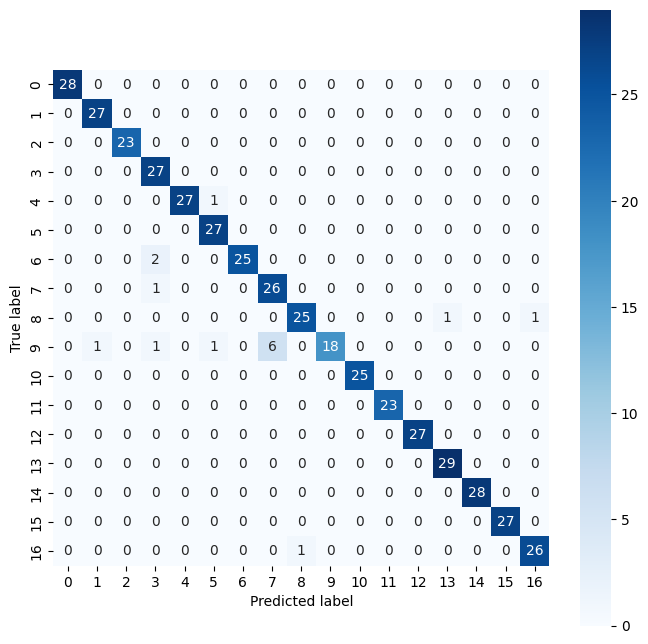

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 取得真實類別標籤
true_classes = test_generator.classes

# 產生混淆矩陣
cm = confusion_matrix(true_classes, predicted_classes)

# 顯示混淆矩陣
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
